# Training a 2D Unet model

In this section, we will demonstrate how to train a U-Net model using pretrained weights. We will make use of some handy libraries:

- [Segmentation-models-pytorch](https://github.com/qubvel/segmentation_models.pytorch): Simply download and import architectures for segmentation and pretrained weights with a few lines of code (similar to [monai.ai](https://monai.io/))
- [Albumentations](https://albumentations.ai/): On-the-fly data augmentation
- [Pytorch lightning](https://lightning.ai/docs/pytorch/stable/): Integrate advanced implementation aspects directly into the model and make your code much more slim

Used Dataset: Müller & Leger et al. (Radiotherapy & Oncology, 2022): Radiomics-based tumor phenotype determination based on medical imaging and tumor microenvironment in a preclinical setting. DOI: https://doi.org/10.1016/j.radonc.2022.02.020 

[Link to Zenodo](https://zenodo.org/record/8249513) ([CC-VY-4.0](https://zenodo.org/record/8249513))

In [2]:
import os
from pathlib import Path
import numpy as np
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
from tempfile import mkdtemp

import albumentations as albu
import torch, torchmetrics
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import segmentation_models_pytorch as smp

In [2]:
torch.cuda.is_available()

True

In [3]:
torch_home = mkdtemp()
os.environ['TORCH_HOME'] = torch_home 

## Dataset preparation

The first thing we have to do for Pytorch training, is tpo create a custom `Dataset` class for our dataset. This dataset object will then serve as a utility through which Pytorch can access and load all the data from the drive. During the training process we will iterate over our dataset, so the `Dataset` implementation needs to have two important member functions:

* `__len__()`: The Dataloader needs to know how *many* samples there are.
* `__getitem__()`: The Dataloader needs to be able to access the i-th sample out of our whole dataset.

In this example, we will create a pandas dataframe with two columns `image` and `mask` and pass this to the Dataset.

In [4]:
class Dataset():
    def __init__(self, root, image_dir='images', label_dir='labels'):
        self.root = root
        
        self.image_dir = os.path.join(root, image_dir)
        self.label_dir = os.path.join(root, label_dir)
        
        # Assuming image and label filenames match, we can just use one list for pairing
        filenames = sorted(os.listdir(self.image_dir))

        # Creating a DataFrame to store paired images and labels
        self.data = pd.DataFrame({
            'image_filenames': [os.path.join(self.image_dir, fname) for fname in filenames],
            'label_filenames': [os.path.join(self.label_dir, fname) for fname in filenames]
        })

    def __getitem__(self, i):
        image_filepath = self.data['image_filenames'].iloc[i]
        label_filepath = self.data['label_filenames'].iloc[i]

        image = io.imread(image_filepath) / 255
        mask = np.argmax(io.imread(label_filepath), axis=2)  # Assuming label images have multiple channels for classes

        # transpose image so that channel dimension comes first
        return image.astype(np.float32).transpose((2, 0, 1)), mask[None, :]

    def __len__(self):
        return len(self.data)

make sure the data is there:

In [5]:
root = r'/projects/p038/p_scads_trainings/BIAS/torch_segmentation_denoising_example_data/HE_image_data'
os.listdir(root)

['best_model.pt', 'images', 'labels']

Let's use this opportunity to quickly check what the above-defined Dataset class does with this. For thhis, we create an instance of the Dataset class using the dataframe with the filenames of our training data. Then we'll try to get an arbitrary sample from the dataset:

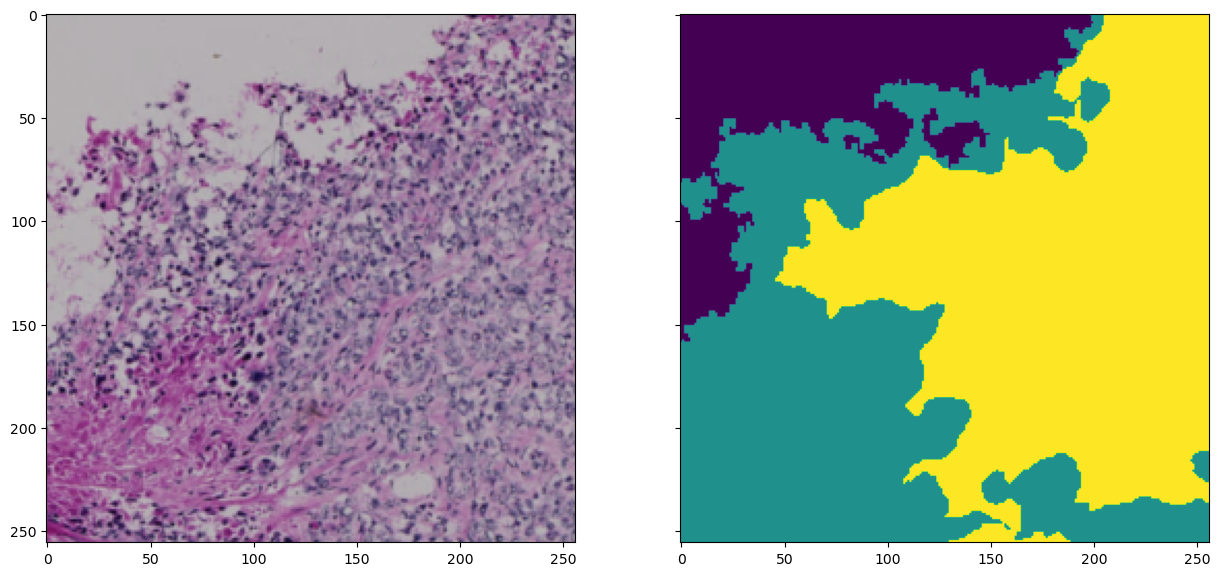

In [6]:
MyDataset = Dataset(root=os.path.join(root))
sample = MyDataset[120]

fig, axes = plt.subplots(ncols=2, figsize=(15, 15), sharex=True, sharey=True)
axes[0].imshow(sample[0].transpose((1,2,0)))  # need to transpose for matplotlib RGB format
axes[1].imshow(sample[1][0])

## Augmentation

For a typical segmentation job, it makes sense to augment the data to a certain degree. Albumentations allows to compose several augmentations together and luckily apply it to the image and the mask alike on-the fly. We will use the following augmentations for the training:
* Vertical flip: Flip the image upside down in 50% of all calls
* Horizontal flip: Same, but horizontal
* Random Rotate: * Randomly rotate image and mask by 90 degrees in 50% of all calls
* Random brightness/contrast: randomly change the brightness/contrast setting of the image in 20% of all calls

In [7]:
aug_train = albu.Compose([
    albu.VerticalFlip(p=1),
    albu.HorizontalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.RandomBrightnessContrast(p=0.8)
])

Run this cell multiple times to observe the effect of the augmentation:

Text(0.5, 1.0, 'Augmented')

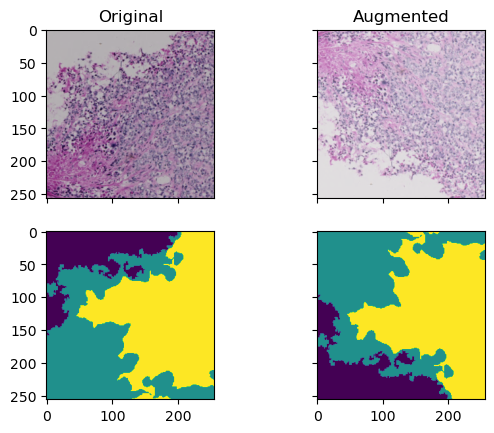

In [8]:
sample = MyDataset[120]
augmented = aug_train(image=sample[0].transpose(1, 2, 0), mask=sample[1].transpose(1, 2, 0))

alpha = 1.0  # Contrast control (1.0 is original contrast)
beta = 0.2   # Brightness control (0 is original brightness)
adjusted_image = np.clip(alpha * augmented['image'] + beta, 0, 1)

fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True)
axes[0, 0].imshow(sample[0].transpose((1,2,0)))  # need to transpose for matplotlib RGB format (XYC)
axes[1, 0].imshow(sample[1][0])
axes[0, 0].set_title('Original')

axes[0, 1].imshow(adjusted_image)
axes[1, 1].imshow(augmented['mask'].squeeze())
axes[0, 1].set_title('Augmented')

### Train/test/validation split

Last but not least, we need to create three subsets from our dataset, a training-, test- and validation-cohort. In every epoch of training (see below), the training process will look at all images in the training cohort and update our model based on this. The model is then applied to the images in the test cohort without updating the model. This is to see how well the method is currently performing. Finally, the model is appliedto the image data in the validation cohort to measure its performance on unknown data.  Scikit-learn provides the KFold strategy for problems like this.

In [11]:
test_size = int(0.1 * len(MyDataset))
train_size = int(0.8 * (len(MyDataset) - test_size))
val_size = len(MyDataset) - test_size - train_size
train_dataset, test_dataset, validation_dataset = torch.utils.data.random_split(MyDataset, [train_size, test_size, val_size])

print('Samples in training set: ', len(train_dataset))
print('Samples in validation set: ', len(validation_dataset))
print('Samples in testing set: ', len(test_dataset))

Samples in training set:  504
Samples in validation set:  126
Samples in testing set:  69


## Model creation and preparation

Next, we have to actually create an instance of a model which we will train for a number of epochs. This section will mostly set some parameters which are explained here.

* `n_classes`: As desribed elsewhere, we are only trying to separate a background nd a foreground here. Hence, there are only 2 classes in our case.
* `epochs`: In one epoch, the the Dataloader will go throough the entire dataset, update the layers and then check the net's performance in the test dataset. This is then repeated `epochs` times
* `batch_size`: During the training process, multiple images are stitched together to a batch of images. This is done along a batch axis that is added to the image data. Typically, images are provided in  `[B, C, Y, X]` shape, with `B` being the batch dimension, `C` the channel dimension and `Y, X` being the actual image dimensions. If the `batch_size` is set too large, the images may not fit on the GPU anymore. 
*Note*: Images in a batch are usually batch-averaged! In other words, the pixel intensity values will be z-score normalized using the commmon mean and standard deviation of the entire batch. Making the batch too small can disrupt these running statistics.

* `learning_rate`: How much the weights of every layer should be changed  in every training step. This is also referred to as the momentum of the training - see [here](https://twitter.com/marktenenholtz/status/1490309316347248646) for a nice explanation!
* `num_workers`: How many CPU cores are allowed to be used to operate the dataloaders to feed the data to the network

In [12]:
epochs = 100
log_interval = 10
n_classes = 3
batch_size = 24
learning_rate = 2e-5
num_workers = 0

## The loss

An aspect of paramount importance is the used **loss function**. After all, deep learning is all about passing data through the network, evaluating the performance and then changing the weights accordingly. The loss function determines how exactlly performance is measured. Torch offers a few different implementations but you can basically implement any metric that compares two label images and calculates something like a degree of similarity. Something that is very commonly used (and thus being used here) is the `CrossEntropyLoss()` function, which calculates the cross-entropy of two label images. The [CrossEntropy ](https://en.wikipedia.org/wiki/Cross_entropy) is closely related to the [Mutual Information](https://en.wikipedia.org/wiki/Cross_entropy).

Since the cross-entropy is a bit abstract to interpret, we will use a more intuitive measure to monitor the performance of our network in the validation cohort: The [Jaccard-coefficient](https://en.wikipedia.org/wiki/Jaccard_index). During the training we should observe that the cross-entropy in the training process goes down while the Jaccard-index should converge closer to 1.

In [13]:
criterion_train = CrossEntropyLoss()
criterion_test = torchmetrics.functional.accuracy

In [14]:
class MyModel(pl.LightningModule):
    def __init__(
        self,
        loss_fn=CrossEntropyLoss(),
        loss_fn_test=torchmetrics.functional.accuracy,
        n_classes=3,
        learning_rate=2e-5,
        training_augmentation=None):
        super(MyModel, self).__init__()

        # store some parameters
        self.learning_rate = learning_rate
        self.loss_fn = loss_fn
        self.loss_fn_test = loss_fn_test
        self.n_classes = n_classes
        self.train_augment = training_augmentation

        self.model = smp.Unet(
            encoder_name='resnet34',
            encoder_weights='imagenet',
            classes=self.n_classes,
            activation=None,
        )

        self.encoder = self.model.encoder
        self.decoder = self.model.decoder

        # log hyperparameters
        self.save_hyperparameters(ignore=['loss_fn'])
    
    def forward(self, x):
        return self.model.forward(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        
        # apply augmentation if we passed it
        if self.train_augment is not None:
            augmented = self.train_augment(image=x.transpose(1, 2, 0), mask=y.transpose(1, 2, 0))
            x = augmented['image'].transpose(2, 0, 1)
            y = augmented['mask'].transpose(2, 0, 1)
            
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y.squeeze())
        self.log("train_loss", loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y.squeeze())
        loss_accuracy = self.loss_fn_test(y_hat.argmax(
            axis=1), y.int().squeeze(), average=None, num_classes=3, task="multiclass")

        log = {'accuracy {}'.format(i): loss_accuracy[i] for i in range(self.n_classes)}
        log["validation_loss"] = loss
        self.log_dict(log)

        # make a matplotlib figure of the prediction if batch index is zero
        if batch_idx == 0:
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            axes[0].imshow(x[0, :, :, :].cpu().numpy().squeeze().transpose(1, 2, 0))
            axes[1].imshow(y[0, 0, :, :].cpu().numpy())
            axes[2].imshow(y_hat.argmax(axis=1)[0, :, :].cpu().numpy())
            self.logger.experiment.add_figure(
                "validation prediction", fig, self.current_epoch)
            
        return loss
    
    def  test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        
        loss = self.loss_fn(y_hat, y.squeeze())
        loss_accuracy = self.loss_fn_test(y_hat.argmax(
            axis=1), y.int().squeeze(), average=None, num_classes=3, task="multiclass")
        
        log = {'Testing accuracy {}'.format(i): loss_accuracy[i] for i in range(self.n_classes)}
        self.log_dict(log)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        return optimizer


### Training

Now we have everything at hand to actually start training! For this, we first create Datasets from our train/test dataframes. Let's not forget to pass the composed albumentations **only to the training dataset.** We could also apply the augmentations to the trainign data, but it is preferable to have performance statistics on the real, unchanged image data.

In [17]:
# Create dataloaders
num_workers = 6
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

Every training epoch follows the following steps:

* Set the model to training mode: In this mode, torch automatically updates the gradients of the model's layers on-the-fly as image data is passed through the layers. The optimizer can then have a look at these gradients to know how the convolutions in the respective layers need to be changed to improve performance
* Reset the gradients known to the optimizer from the previous epoch
* Pass each batch of training data through the network and calculate the loss (deviation of acquired result and correct mask)
* Back-propagate the loss through the network and calculate the gradients
* Let the optimizer update the weights of the network

To check the progress of the training, navigate to the working directory in a terminal and open the tensorboard with

```
tensorboard --logdir=runs
```

Then, navigate to http://localhost:6006/ in the browser.

In [18]:
model = MyModel()
model.train(True)

MyModel(
  (loss_fn): CrossEntropyLoss()
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [19]:
logfolder = Path("lightning_outputs")
if not logfolder.is_dir():
    logfolder.mkdir()

In [20]:
checkpoint_callback = ModelCheckpoint(
    filename='{epoch:03.0f}-{train_loss:.3f}',
    save_last=True,
    save_top_k=1,
    monitor="train_loss",
    every_n_epochs=1
)

In [21]:
early_stop_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor='validation_loss',
    min_delta=0.00,
    patience=5
)

In [22]:
use_cuda = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
trainer = pl.Trainer(
    default_root_dir=logfolder,
    max_epochs=epochs,
    log_every_n_steps=log_interval,
    accelerator="gpu" if use_cuda else "cpu",
    devices=ndevices if use_cuda else 1,
    num_sanity_val_steps=0,
    callbacks=[
        checkpoint_callback,
        early_stop_callback
    ]
)

/app/env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /app/env/lib/python3.10/site-packages/ipykernel_laun ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


*Note*: If you want to visualize the progress of the training, you can use the [Tensorboard](https://www.tensorflow.org/tensorboard). To make it work on the HPC, run the following lines in a terminal:

```bash
mkdir -p /tmp/$USER/tf-logs
ln -s ~/PoL-BioImage-Analysis-TS-GPU-Accelerated-Image-Analysis/docs/70_AI_Segmentation_Denoising/lightning_outputs /tmp/$USER/tf-logs

tensorboard --logdir ~/PoL-BioImage-Analysis-TS-GPU-Accelerated-Image-Analysis/docs/70_AI_Segmentation_Denoising/lightning_outputs --bind_all
```

In [ ]:
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataloader)

## Validation

As a last step, we need to check how well the model performed on completely unseen data - the testing dataset. 

**Important**: For simplicity, we create the training/validation/testing data within this notebook further above:

```python
torch.utils.data.random_split(MyDataset, [train_size, test_size, val_size])
```

**DO NOT DO THIS AT HOME** - it is better to keep the datasets completely separate on your drive and rather create three, independent instanves of `MyDataset` first.

In [24]:
# test the model
trainer.test(model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/app/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:486: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Testing accuracy 0     │    0.9514293074607849     │
│    Testing accuracy 1     │    0.8477627635002136     │
│    Testing accuracy 2     │    0.8829793334007263     │
└───────────────────────────┴───────────────────────────┘

[{'Testing accuracy 0': 0.9514293074607849,
  'Testing accuracy 1': 0.8477627635002136,
  'Testing accuracy 2': 0.8829793334007263}]

We can also check the performance of both the last and the best model. Look up the name of the best model in the `./lightning_outputs/lightning_logs/version_X/checkpoints/`. You may have to use the terminal to navigate there. Make sure to replace `version_X` with the correct folder name:

`cd PoL-BioImage-Analysis-TS-GPU-Accelerated-Image-Analysis/docs/70_AI_Segmentation_Denoising/lightning_outputs/lightning_logs/version_X/checkpoints/`

In [25]:
best_model = MyModel.load_from_checkpoint("./lightning_outputs/lightning_logs/version_3/checkpoints/epoch=020-train_loss=0.176.ckpt")
last_model = MyModel.load_from_checkpoint("./lightning_outputs/lightning_logs/version_3/checkpoints/last.ckpt")
best_model.eval()
last_model.eval()

MyModel(
  (loss_fn): CrossEntropyLoss()
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [26]:
trainer.test(best_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Testing accuracy 0     │    0.9471439719200134     │
│    Testing accuracy 1     │     0.901079535484314     │
│    Testing accuracy 2     │    0.9415451288223267     │
└───────────────────────────┴───────────────────────────┘

[{'Testing accuracy 0': 0.9471439719200134,
  'Testing accuracy 1': 0.901079535484314,
  'Testing accuracy 2': 0.9415451288223267}]

In [27]:
trainer.test(last_model, dataloaders=test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Testing accuracy 0     │    0.9601063132286072     │
│    Testing accuracy 1     │    0.9204296469688416     │
│    Testing accuracy 2     │    0.9238709211349487     │
└───────────────────────────┴───────────────────────────┘

[{'Testing accuracy 0': 0.9601063132286072,
  'Testing accuracy 1': 0.9204296469688416,
  'Testing accuracy 2': 0.9238709211349487}]

## Inference

Last but not least, let's apply the trained model to some data

In [42]:
n_show = 10
idxs_to_show = np.random.randint(low=0, high=len(test_dataset), size=n_show)
image_batch = np.stack([test_dataset[i][0] for i in idxs_to_show])
label_batch = np.stack([test_dataset[i][1] for i in idxs_to_show])

with torch.no_grad():
    prediction = best_model(torch.tensor(image_batch))
    prediction = prediction.detach().cpu().numpy()

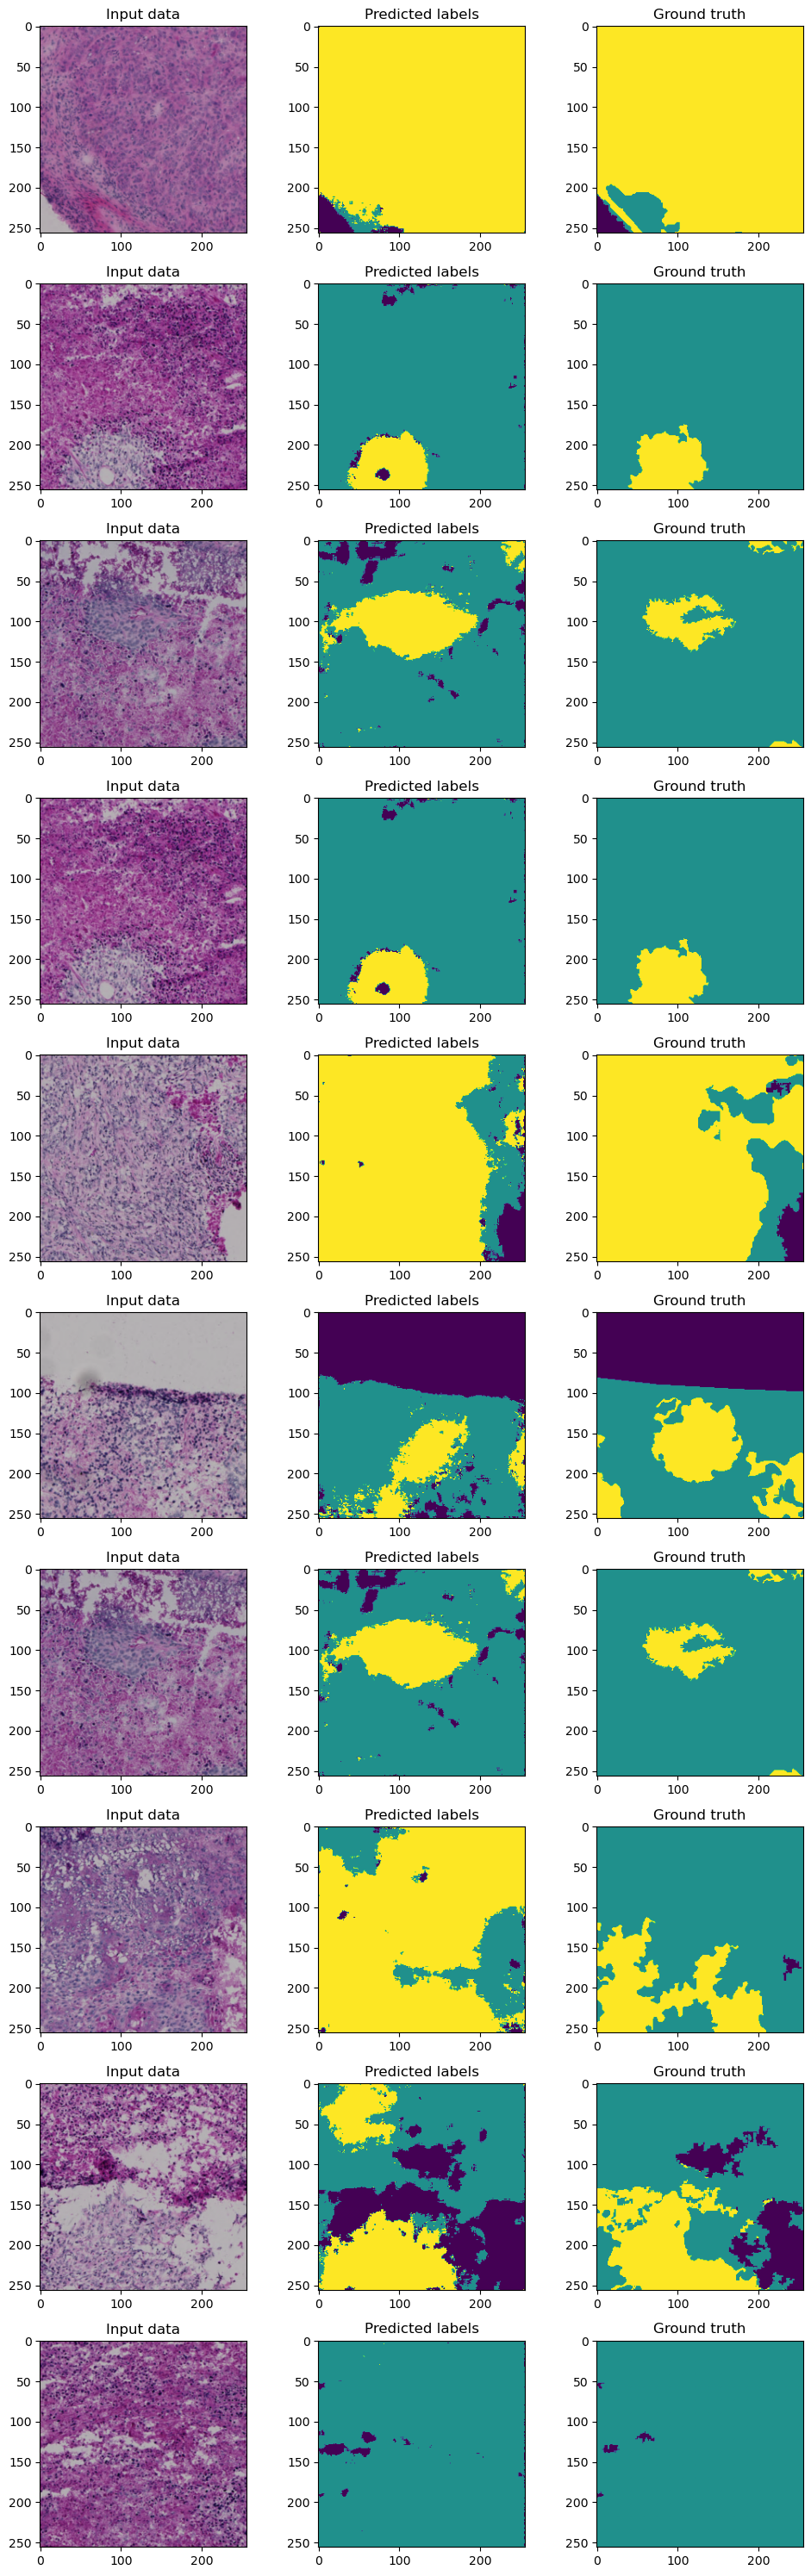

In [46]:
fig, axes = plt.subplots(ncols=3, nrows=n_show, figsize=(10, 3*n_show))

for i in range(n_show):
    axes[i, 0].imshow(image_batch[i].transpose((1, 2, 0)))
    axes[i, 0].set_title('Input data')
    axes[i, 1].imshow(np.argmax(prediction[i], axis=0), vmin=0, vmax=2)
    axes[i, 1].set_title('Predicted labels')
    axes[i, 2].imshow(label_batch[i].squeeze(), vmin=0, vmax=2)
    axes[i, 2].set_title('Ground truth')

fig.tight_layout()